# Titanic - Machine Learning from Disaster

<img src="https://www.cnnbrasil.com.br/wp-content/uploads/sites/12/2023/06/titanic_navio_1912-e1687528104691.jpg?w=876&h=484&crop=1" width=900>

- Vamos empregar os dados atualmente acessíveis no Kaggle. [dados disponíveis no Kaggle](https://www.kaggle.com/competitions/titanic)
    - Trata-se de um conjunto de dados destinado a uma competição
    - A avaliação do desempenho decorre com base na acurácia:

  *Sua pontuação reflete a porcentagem de passageiros que você é capaz de prever com precisão. Esse índice é conhecido como acurácia.*

### Importando novamente as bases e fazendo o tratamento dos dados
- Vamos apenas replicar o que fizemos no **[primeiro](https://github.com/Raqueljkl1/Titanic/blob/main/An%C3%A1lise_do_Titanic_Parte_1.ipynb)** e no **[segundo](https://github.com/Raqueljkl1/Titanic/blob/main/Analise_do_Titanic_Parte_2.ipynb)** arquivo dessa análise (para visualizar os arquivos completos, visite esse link)

In [293]:
# Realizando todas as importações necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree


In [294]:
# Visualizando a base de treino
train = pd.read_csv('train.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [295]:
# Visualizando a base de teste
test = pd.read_csv('test.csv')
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


- **Fazendo o mesmo tratamento inicial que fizemos nas aulas anteriores**

In [296]:
# Eliminando as colunas com elevada cardinalidade
train = train.drop(['Name','Ticket','Cabin'],axis=1)
test = test.drop(['Name','Ticket','Cabin'],axis=1)

In [297]:
# Usando a média para substituir valores nulos na coluna de idade
train.loc[train.Age.isnull(),'Age'] = train.Age.mean()
test.loc[test.Age.isnull(),'Age'] = test.Age.mean()

In [298]:
# Tratando a coluna Embarked da base de treino usando a moda
train.loc[train.Embarked.isnull(),'Embarked'] = train.Embarked.mode()[0]

In [299]:
# E também a coluna Fare da base de teste usando a média
test.loc[test.Fare.isnull(),'Fare'] = test.Fare.mean()

In [300]:
# Usando uma lambda function para tratar a coluna "Sex"
train['MaleCheck'] = train.Sex.apply(lambda x: 1 if x == 'male' else 0)
test['MaleCheck'] = test.Sex.apply(lambda x: 1 if x == 'male' else 0)

- E vamos usar o **[OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)** para tratar a coluna Embarked

In [301]:
# Criando o encoder e fazendo o fit com os dados
ohe = OneHotEncoder(handle_unknown='ignore',dtype='int32')
ohe = ohe.fit(train[['Embarked']])

In [302]:
# Atualizando a base de treino com os novos valores
ohe_df = pd.DataFrame(ohe.transform(train[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())
train = pd.concat([train,ohe_df],axis=1)

In [303]:
# e a base de teste
ohe_df = pd.DataFrame(ohe.transform(test[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())
test = pd.concat([test,ohe_df],axis=1)

In [304]:
# Podemos então apagar essas duas colunas que já tratamos
train = train.drop(['Sex','Embarked'],axis=1)
test = test.drop(['Sex','Embarked'],axis=1)

- Visualizando a base resultante

In [305]:
# Visualizando a base de treino
train.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,1


- Podemos já [utilizar essa base no modelo](#modelo) para efeitos de comparação com as melhorias que vamos fazer abaixo

<a name='ajustes'></a>
### Vamos fazer alguns ajustes nos dados para melhorar o resultado do nosso modelo
- [Podemos começar analisando a escala dos dados](#escala)
- [Depois podemos entender as colunas SibSp e Parch](#familia)
- [Selecionando as melhores variáveis do modelo](#f_selection)
    - [Entendendo a relação entre **Pclass e Fare**](#PclassFare)
    - [Entendendo sobre as **colunas de embarque**](#Embarque)
    - [Entendendo agora as **colunas de família**](#Familia)

<a name='escala'></a>
#### Analisando a escala dos dados
- As colunas **"Age" e "Fare"** estão em uma **escala muito diferente das outras**, podemos começar fazendo um ajuste nessas escalas
    - Vamos usar os **[ajustes de escala do próprio Scikit-Learn](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)**
    - Como essas colunas possuem outliers, podemos começar tentando utilizar o **[RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)**

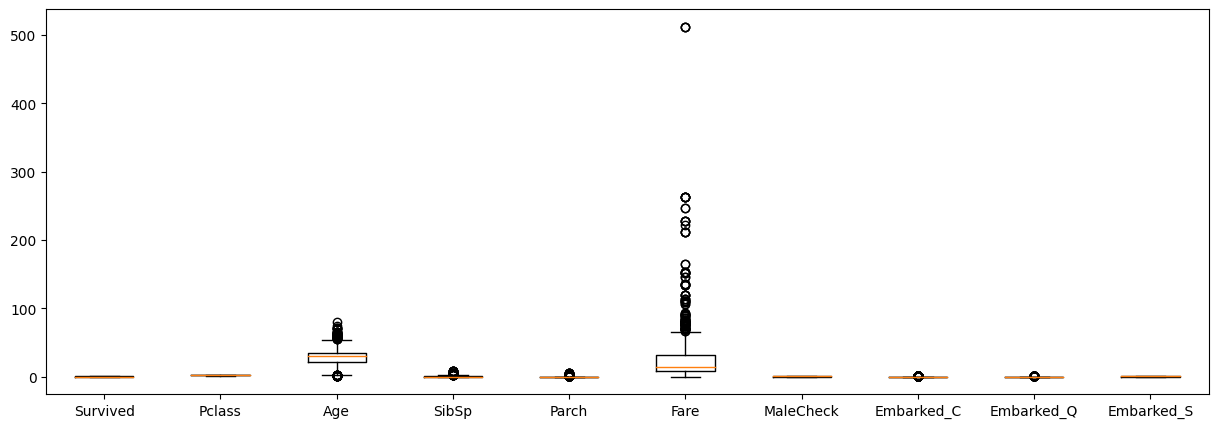

In [181]:
# Visualizando a escala desses dados

fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(train.iloc[:,1:11])
ax.set_xticks(range(1,train.iloc[:,1:11].shape[1]+1),train.iloc[:,1:11].columns)

plt.show()

**Insight:** Analisando o gráfico acima, observamos que as variáveis  "**Age**" e "**Fare**" em uma escala muito diferente.

Vamos utilizar o RobustScaler do scikit-learn para dimensionar as colunas "Age" e "Fare". O RobustScaler é uma escolha sólida quando há presença de outliers nos dados, pois ele utiliza estatísticas robustas (mediante os quartis) em vez de média e desvio padrão, o que o torna mais resiliente a valores extremos.

In [306]:
# Criando o scaler
transformer = RobustScaler().fit(train[['Age','Fare']])

In [307]:
# Fazendo o transformação dos dados
train[['Age','Fare']] = transformer.transform(train[['Age','Fare']])

In [308]:
# Fazendo o mesmo para a base de teste
transformer = RobustScaler().fit(test[['Age','Fare']])
test[['Age','Fare']] = transformer.transform(test[['Age','Fare']])

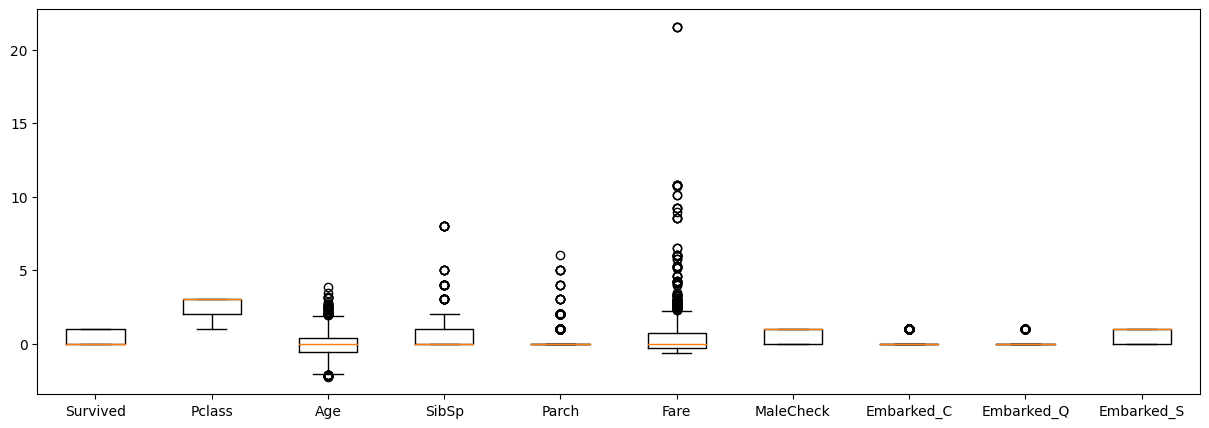

In [309]:
# Visualizando novamente os dados
fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(train.iloc[:,1:11])
ax.set_xticks(range(1,train.iloc[:,1:11].shape[1]+1),train.iloc[:,1:11].columns)

plt.show()

**Insights:** Após utilizarmos o RobustScaler, as variáveis se encontram em escalas muito mais próximas.

- Podemos já [utilizar essa base no modelo](#modelo) para verificar o resultado



---



<a name='familia'></a>
#### Entendendo as colunas SibSp e Parch
- Agora podemos entender as colunas **SibSp** e **Parch**
    - **SibSp**: Nº de irmãos/cônjuges a bordo do Titanic
    - **Parch**: Nº de pais/filhos a bordo do Titanic
- Podemos verificar quantas pessoas sobreviveram em cada um dos valores dessa coluna

In [224]:
# Verificando a sobrevivência para SibSp
SibSp_df = train.groupby('SibSp')['Survived'].agg(['sum','count','mean']).reset_index()
SibSp_df.columns = ['SibSp','sobrev','total','tx_sobrev']
SibSp_df

,SibSp,sobrev,total,tx_sobrev
0,0,210,608,0.345395
1,1,112,209,0.535885
2,2,13,28,0.464286
3,3,4,16,0.250000
4,4,3,18,0.166667
5,5,0,5,0.000000
6,8,0,7,0.000000


In [184]:
# Verificando a sobrevivência para Parch
Parch_df = train.groupby('Parch')['Survived'].agg(['sum','count','mean']).reset_index()
Parch_df.columns = ['Parch','sobrev','total','tx_sobrev']
Parch_df

,Parch,sobrev,total,tx_sobrev
0,0,233,678,0.343658
1,1,65,118,0.550847
2,2,40,80,0.500000
3,3,3,5,0.600000
4,4,0,4,0.000000
5,5,1,5,0.200000
6,6,0,1,0.000000


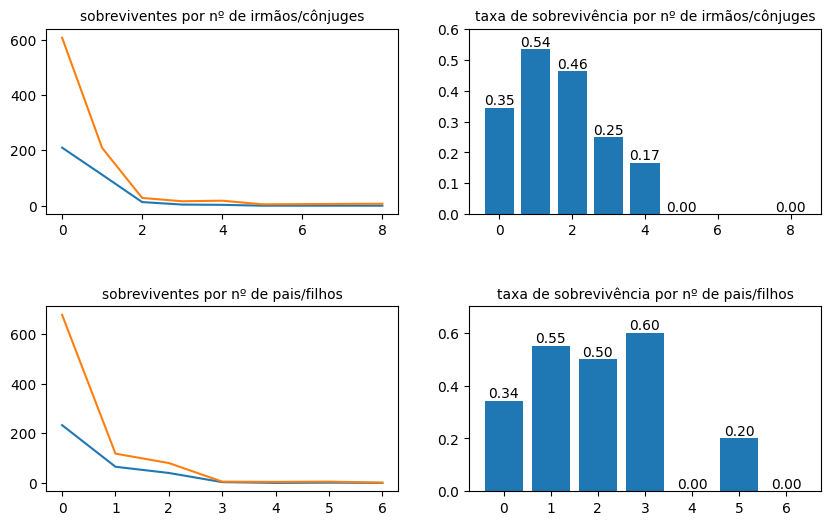

In [62]:
# Visualizando essas informações graficamente
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,6))

ax[0,0].plot(SibSp_df.SibSp, SibSp_df.sobrev)
ax[0,0].plot(SibSp_df.SibSp, SibSp_df.total)
ax[0,0].set_title('sobreviventes por nº de irmãos/cônjuges', fontsize=10)

labels1 = ax[0,1].bar(SibSp_df.SibSp, SibSp_df.tx_sobrev)
ax[0,1].bar_label(labels1,fmt="%.02f")
ax[0,1].set(ylim=(0,0.6))
ax[0,1].set_title('taxa de sobrevivência por nº de irmãos/cônjuges', fontsize=10)

ax[1,0].plot(Parch_df.Parch, Parch_df.sobrev)
ax[1,0].plot(Parch_df.Parch, Parch_df.total)
ax[1,0].set_title('sobreviventes por nº de pais/filhos', fontsize=10)

labels2 = ax[1,1].bar(Parch_df.Parch, Parch_df.tx_sobrev)
ax[1,1].bar_label(labels2,fmt="%.02f")
ax[1,1].set(ylim=(0,0.7))
ax[1,1].set_title('taxa de sobrevivência por nº de pais/filhos', fontsize=10)

plt.subplots_adjust(hspace=0.5)

plt.show()

**Insights**:  Foi observado que os passageiros que viajaram sozinhos apresentaram uma taxa de sobrevivência menor em comparação com aqueles que estavam acompanhados.

- Podemos criar uma nova coluna identificando se o passageiro está viajando sozinho

In [63]:
# Criando uma função para verificar se os dois valores são vazios
def sozinho(a,b):
    if (a == 0 and b == 0):
        return 1
    else:
        return 0

In [225]:
# Aplicando essa função na base de treino
train['Sozinho'] = train.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)

In [226]:
# Verificando os valores nessa coluna
train.groupby('Sozinho')[['SibSp','Parch']].mean()

,SibSp,Parch
Sozinho,,
0,1.316384,0.960452
1,0.000000,0.000000


In [227]:
# Fazendo o mesmo para a base de teste
test['Sozinho'] = test.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)

- Podemos também **criar uma nova coluna** sendo o **total de familiares a bordo**

In [228]:
# Criando para a base de treino
train['Familiares'] = train.SibSp + train.Parch

In [229]:
# E para a base de teste
test['Familiares'] = train.SibSp + train.Parch

In [230]:
# Verificando a sobrevivência para Familiares
Familiares_df = train.groupby('Familiares')['Survived'].agg(['sum','count','mean']).reset_index()
Familiares_df.columns = ['Familiares','sobrev','total','tx_sobrev']
Familiares_df

,Familiares,sobrev,total,tx_sobrev
0,0,163,537,0.303538
1,1,89,161,0.552795
2,2,59,102,0.578431
3,3,21,29,0.724138
4,4,3,15,0.200000
5,5,3,22,0.136364
6,6,4,12,0.333333
7,7,0,6,0.000000
8,10,0,7,0.000000


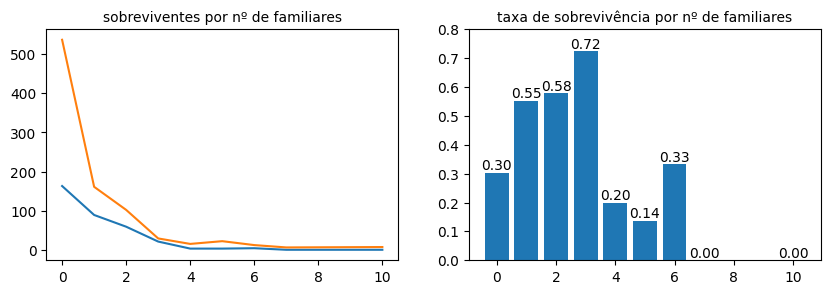

In [70]:
# Visualizando a informação de familiares
fig, ax = plt.subplots(ncols=2,figsize=(10,3))

ax[0].plot(Familiares_df.Familiares, Familiares_df.sobrev)
ax[0].plot(Familiares_df.Familiares, Familiares_df.total)
ax[0].set_title('sobreviventes por nº de familiares', fontsize=10)

labels1 = ax[1].bar(Familiares_df.Familiares, Familiares_df.tx_sobrev)
ax[1].bar_label(labels1,fmt="%.02f")
ax[1].set(ylim=(0,0.8))
ax[1].set_title('taxa de sobrevivência por nº de familiares', fontsize=10)

plt.show()

**Insights:** Verificamos que até 3 familiares a bordo, a taxa de sobrevivencia sobe consideravelmente.

- Podemos já utilizar essa base no [modelo](#modelo) para verificar o resultado

<a name="f_selection"></a>
#### Selecionando os melhores recursos
- Primeiramente precisamos analisar qual a **correlação entre as variáveis** e verificar se não existem variáveis que estão basicamente "dizendo a mesma coisa"

In [231]:
# Visualizando a base
train.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
0,1,0,3,-0.648831,1,0,-0.305208,1,0,0,1,0,1
1,2,1,1,0.606071,1,0,2.407584,0,1,0,0,0,1
2,3,1,3,-0.335105,0,0,-0.276612,0,0,0,1,1,0


In [232]:
# Analisando a correlação entre as variáveis
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
PassengerId,1.000000,-0.005007,-0.035144,0.033207,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022204,0.057462,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.149683,-0.203367,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.074053,0.135207,0.065997
Age,0.033207,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,0.084153,0.032024,-0.013855,-0.019336,0.179775,-0.248512
SibSp,-0.057527,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.068734,-0.584471,0.890712
Parch,-0.001652,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.060814,-0.583398,0.783111
Fare,0.012658,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.162184,-0.271832,0.217138
MaleCheck,0.042939,-0.543351,0.131900,0.084153,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.119224,0.303646,-0.200988
Embarked_C,-0.001205,0.168240,-0.243292,0.032024,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.782742,-0.095298,-0.046215
Embarked_Q,-0.033606,0.003650,0.221009,-0.013855,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.499421,0.086464,-0.058592


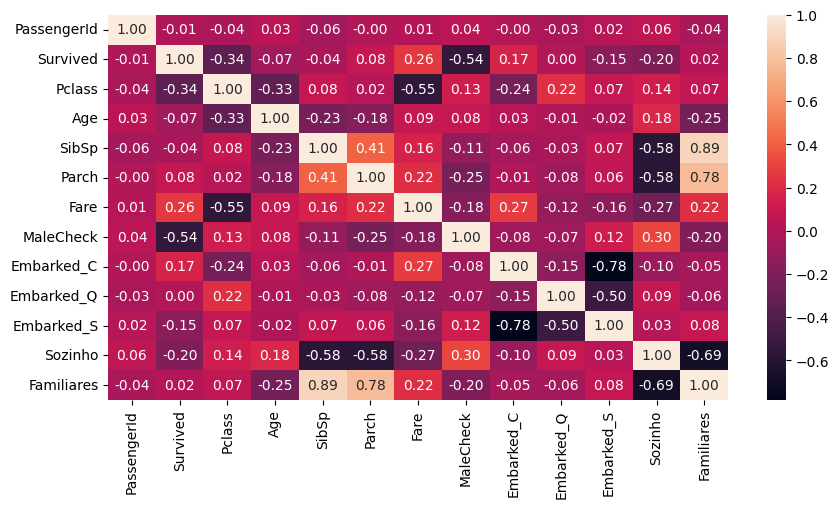

In [233]:
# Tornando a correlação mais visual
fig, ax = plt.subplots(figsize=(10,5))

sns.heatmap(train.corr(), annot=True, fmt=".2f")

plt.show()

**Insights:** Ao examinarmos o gráfico anterior, fica evidente a existência de uma correlação entre essas variáveis. Essa correlação se torna compreensível quando consideramos que aqueles na primeira classe provavelmente fizeram pagamentos mais elevados. Nos passos subsequentes, iremos aprofundar nossa compreensão dessa relação de maneira mais abrangente.

<a name='PclassFare'></a>
- <font color='blue'> Entendendo a relação entre **Pclass e Fare** </font>

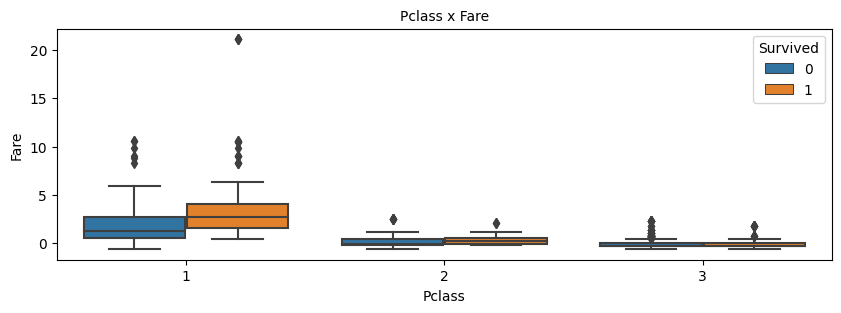

In [234]:
# Visualizando a relação entre essas variáveis
fig, ax = plt.subplots(figsize=(10,3))

sns.boxplot(data=train,x='Pclass',y='Fare',hue='Survived')
ax.set_title('Pclass x Fare', fontsize=10)

plt.show()

**Insights:** No gráfico acima, é evidente que há indivíduos da primeira classe que pagaram quantias equivalentes aos passageiros da terceira classe. No entanto, é notável que aqueles que efetuaram pagamentos mais elevados parecem apresentar uma probabilidade maior de sobrevivência.

In [235]:
# Verificando a taxa de sobrevivência em cada uma das classes
train.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [236]:
# Entendendo a relação entre Pclass x Fare
train.groupby(['Pclass','Survived'])['Fare'].agg(['min','mean','max'])

min      mean        max
Pclass Survived                               
1      0        -0.612357  2.128003  10.529728
       1         0.486142  3.438110  21.092645
2      0        -0.612357  0.210053   2.501495
       1        -0.167521  0.322040   2.141390
3      0        -0.612357 -0.033250   2.334152
       1        -0.612357 -0.032169   1.781107

- Nesse momento pode surgir a pergunta do motivo de termos **pessoas pagando o mesmo preço em classes diferentes**
    - Procurando no Kaggle, [essa resposta](https://www.kaggle.com/questions-and-answers/128215) ajuda a explicar um pouco:


_"Se você conseguiu economizar e guardar todo o seu dinheiro para uma viagem para mudar sua vida e ir para a América, você é uma terceira classe, um imigrante que precisa trazer sua própria comida a bordo e ter em mente como suas provisões se sustentariam. A segunda classe era formada por trabalhadores de colarinho branco que podiam se dar ao luxo de viajar com um pouco de lazer, sem se preocupar com algo tão comum como comida. Primeira classe significa que você nasceu com dinheiro e não precisa sujar as mãos com o trabalho. Eles não eram separados apenas pelo custo, eles também eram separados por onde poderiam ir e o que recebiam."_

- Também tem um link do Reddit que detalha bem essa questão de classe x preço
    - https://www.reddit.com/r/AskHistorians/comments/11dlsn6/why_was_the_cost_of_tickets_on_the_titanic_so/?onetap_auto=true
    - Podemos pensar em direcionar uma **análise relacionando ao preço da cabine**, porém **essa variável possui 77.1% dos valores vazios**

<a name='Embarque'></a>
- <font color='blue'> Entendendo sobre as **colunas de embarque** </font>
    - Inicialmente pensamos não existir relação de ordem entre a coluna de embarque, mas pesquisando [nesse artigo](https://pt.wikipedia.org/wiki/RMS_Titanic) percebemos que **existe sim essa correlação**
    
    
_"O Titanic deixou o porto de **Southampton**...Em seguida ele foi para **Cherbourg-Octeville** na França...em sua maioria da primeira classe.O Titanic então rumou para **Queenstown** na Irlanda...principalmente imigrantes da terceira classe que pretendiam tentar a vida nos Estados Unidos."_

In [237]:
# Podemos importar novamente as bases para "recuperar" a coluna de embarque
train2 = pd.read_csv('train.csv')
test2 = pd.read_csv('test.csv')

train2.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [240]:
# Como temos valores vazios, podemos novamente fazer o tratamento dos dados
train2['Embarked'] = train2['Embarked'].fillna('S')

- O que podemos fazer agora é colocar o porto em ordem de embarque (S depois C e depois Q)
    - Podemos fazer isso através do **[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)**

In [238]:
# Criando o encoder
categorias = ['S','C','Q']

enc = OrdinalEncoder(categories=[categorias],dtype='int32')

In [241]:
# Fazendo o fit com os dados
enc = enc.fit(train2[['Embarked']])

In [242]:
# Podemos então adicionar essa coluna na base de treino original
train['Embarked'] = enc.transform(train2[['Embarked']])

In [243]:
# E fazer o fit com os dados de teste
enc = enc.fit(test2[['Embarked']])

In [244]:
# E adicionar na base de teste original
test['Embarked'] = enc.transform(test2[['Embarked']])

In [245]:
# Agora podemos eliminar as colunas desnecessárias
train = train.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis=1)
test = test.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis=1)

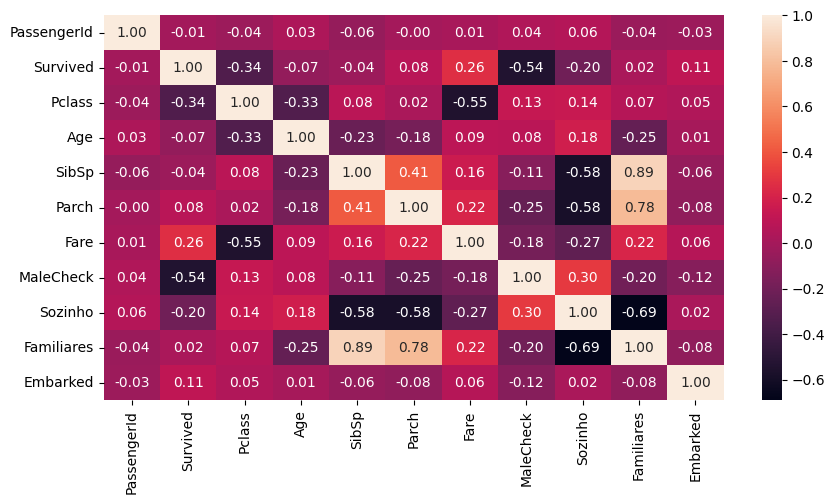

In [246]:
# Visualizando novamente a correlação
fig, ax = plt.subplots(figsize=(10,5))

sns.heatmap(train.corr(), annot=True, fmt=".2f")

plt.show()

<a name='Familia'></a>
- <font color='blue'> Entendendo agora as **colunas de família** </font>
    - Podemos usar a regressão logística e a árvore de classificação para verificar a importância de cada uma dessas colunas

In [247]:
# Separando X e y
X = train.drop(['PassengerId','Survived'],axis=1)
y = train.Survived

In [248]:
# Usando a regressão logística nos dados
clf_rl = LogisticRegression(random_state=42,max_iter=1000).fit(X,y)

In [254]:
# Verificando a importância
clf_rl.coef_[0]

array([-1.03324742, -0.48705937, -0.26823499,  0.01694416,  0.04495354,
       -2.53455979, -0.7323543 , -0.25129083,  0.23860782])

In [255]:
# Agora usando a árvore de classificação
clf_ac = tree.DecisionTreeClassifier(random_state=42).fit(X,y)

In [256]:
# Verificando a importância
clf_ac.feature_importances_

array([0.10901775, 0.22826711, 0.01907221, 0.0272942 , 0.23870173,
       0.30933519, 0.00397775, 0.04365035, 0.02068372])

In [257]:
# Criando um DataFrame
imp = pd.DataFrame({
    'colunas': X.columns,
    'reg. log.': clf_rl.coef_[0],
    'arvore': clf_ac.feature_importances_
})

imp

,colunas,reg. log.,arvore
0,Pclass,-1.033247,0.109018
1,Age,-0.487059,0.228267
2,SibSp,-0.268235,0.019072
3,Parch,0.016944,0.027294
4,Fare,0.044954,0.238702
5,MaleCheck,-2.534560,0.309335
6,Sozinho,-0.732354,0.003978
7,Familiares,-0.251291,0.043650
8,Embarked,0.238608,0.020684


In [258]:
# Podemos apenas manter as colunas mais relevantes
train = train.drop(['SibSp','Parch'],axis=1)
test = test.drop(['SibSp','Parch'],axis=1)

<a name="modelo"></a>

### Usando essa nova base no modelo

In [310]:
# Visualizando a base
train.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,-0.592240,1,0,-0.312011,1,0,0,1
1,2,1,1,0.638529,1,0,2.461242,0,1,0,0
2,3,1,3,-0.284548,0,0,-0.282777,0,0,0,1


- Podemos selecionar os mesmos modelos que vimos anteriormente (consulte arquivo da **[parte 1](https://github.com/lucaslealx/Titanic/blob/main/Parte1.ipynb)**)
    - **Árvore de classificação**
        - https://scikit-learn.org/stable/modules/tree.html#classification
    - **Classificação dos vizinhos mais próximos**
        - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
    - **Regressão Logística**
        - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
- Antes de usar os algoritmos, precisamos separar a base de treino em **treino e validação**
    - Vamos fazer isso utilizando o **train_test_split**
        - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [311]:
# Separando a base de treino em X e y
X = train.drop(['PassengerId','Survived'],axis=1)
y = train.Survived

In [312]:
# Separando em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

- Para a **árvore de classificação**

In [313]:
# Criando o classificador
clf_ac = tree.DecisionTreeClassifier(random_state=42)

In [314]:
# Fazendo o fit com os dados
clf_ac = clf_ac.fit(X_train,y_train)

In [315]:
# Fazendo a previsão
y_pred_ac = clf_ac.predict(X_val)

- Para o **KNeighborsClassifier**

In [316]:
# Criando o classificador
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [317]:
# Fazendo o fit com os dados
clf_knn = clf_knn.fit(X_train,y_train)

In [318]:
# Fazendo a previsão
y_pred_knn = clf_knn.predict(X_val)

- E para a **Regressão Logística**

In [319]:
# Criando o classificador
clf_rl = LogisticRegression(random_state=42,max_iter=1000)

In [320]:
# Fazendo o fit com os dados
clf_rl = clf_rl.fit(X_train,y_train)

In [321]:
# Fazendo a previsão
y_pred_rl = clf_rl.predict(X_val)

- Vamos novamente **avaliar os modelos**
    - Acurácia (método de avaliação usado na competição):
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    - Matriz de confusão (ajuda a visualizar a distribuição dos erros):
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

- Avaliando a **acurácia**

In [322]:
# Para a árvore
as_ac = accuracy_score(y_val, y_pred_ac)
as_ac

0.7491525423728813

In [323]:
# Para o knn
as_knn = accuracy_score(y_val, y_pred_knn)
as_knn

0.8

In [324]:
# Para a regressão logística
as_rl = accuracy_score(y_val, y_pred_rl)
as_rl

0.8169491525423729

- Podemos salvar esses valores em um DataFrame para visualizarmos nossa evolução

In [30]:
#Criando primeiramente o DataFrame
as_df = pd.DataFrame({
    'modelos': ['arvore','knn','reg. log.'],
    'inicial': [as_ac,as_knn,as_rl]
})

as_df

,modelos,inicial
0,arvore,0.749153
1,knn,0.715254
2,reg. log.,0.816949


In [285]:
# Adicionando novas colunas no DafaFrame
# as_df['escala'] = [as_ac,as_knn,as_rl]
# as_df['pessoas'] = [as_ac,as_knn,as_rl]
as_df['colunas'] = [as_ac,as_knn,as_rl]

In [286]:
# Visualizando
as_df

,modelos,inicial,escala,pessoas,colunas
0,arvore,0.749153,0.749153,0.735593,0.762712
1,knn,0.715254,0.800000,0.786441,0.786441
2,reg. log.,0.816949,0.816949,0.806780,0.810169


- Avaliando a **matriz de confusão**

In [287]:
# Para a árvore
confusion_matrix(y_val, y_pred_ac)

array([[142,  33],
       [ 37,  83]])

In [288]:
# Para o knn
confusion_matrix(y_val, y_pred_knn)

array([[149,  26],
       [ 37,  83]])

In [289]:
# Para a regressão logística
confusion_matrix(y_val, y_pred_rl)

array([[154,  21],
       [ 35,  85]])

- Sempre que quisermos, podemos **[voltar](#ajustes)** e continuar fazendo os ajustes necessários na nossa base

### Fazendo a previsão para os dados de teste
- Vamos usar o modelo com melhor precisão para fazer o predict na base de teste

In [325]:
# Visualizando o X_train
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
6,1,1.869299,0,0,1.620136,1,0,0,1
718,3,0.000000,0,0,0.045293,1,0,1,0
685,2,-0.361471,1,2,1.174771,1,1,0,0


In [326]:
# Visualizando a base de teste
test.head(3)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0.331562,0,0,-0.280670,1,0,1,0
1,893,3,1.311954,1,0,-0.315800,0,0,0,1
2,894,2,2.488424,0,0,-0.201943,1,0,1,0


In [327]:
# Para a base de teste ser igual a base de treino, precisamos eliminar a coluna de id
X_teste = test.drop('PassengerId',axis=1)
# Utilizando a regressão logística na base de teste
y_pred = clf_rl.predict(X_teste)
# Criando uma nova coluna com a previsão na base de teste
test['Survived'] = y_pred
# Selecionando apenas a coluna de Id e Survived para fazer o envio
base_envio = test[['PassengerId','Survived']]
# Exportando para um csv
base_envio.to_csv('resultados_escala.csv',index=False)